In 2013, students of the Statistics class at FSEV UK were asked to invite their friends to participate in this survey.

The data file (responses.csv) consists of 1010 rows and 150 columns (139 integer and 11 categorical).
For convenience, the original variable names were shortened in the data file. See the columns.csv file if you want to match the data with the original names.
The data contain missing values.
The survey was presented to participants in both electronic and written form.
The original questionnaire was in Slovak language and was later translated into English.
All participants were of Slovakian nationality, aged between 15-30.
The variables can be split into the following groups:

Music preferences (19 items)
Movie preferences (12 items)
Hobbies & interests (32 items)
Phobias (10 items)
Health habits (3 items)
Personality traits, views on life, & opinions (57 items)
Spending habits (7 items)
Demographics (10 items)

* Correlation analysis: Are there any connections between music and movie preferences?
* Visualization: How to effectively visualize a lot of variables in order to gain some meaningful insights from the data?
* (Multivariate) Outlier detection: Small number of participants often cheats and randomly answers the questions. Can you identify them? Hint: Local outlier factor may help.
* Missing values analysis: Are there any patterns in missing responses? What is the optimal way of imputing the values in surveys?

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# styling
pd.set_option('display.max_columns',150)
plt.style.use('bmh')
from IPython.display import display

# a bit of machine learning
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline

In [2]:
dir_path = os.path.abspath('')

In [3]:
file = '/young-people-survey/responses.csv'

In [4]:
young = pd.read_csv(os.path.join(dir_path + file))

In [6]:
young.head(10)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,1.0,2.0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,5.0,3.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,5.0,3.0,3.0,2.0,1.0,5.0,5.0,1.0,4.0,4.0,2.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,5,3.0,1.0,3.0,2.0,never smoked,drink a lot,4.0,2.0,2.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,3.0,5.0,1.0,1.0,3.0,4.0,1.0,3.0,1.0,3.0,1,4.0,5.0,4.0,3.0,2.0,1.0,1.0,1.0,4,2.0,3,i am always on time,never,3.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,1.0,4.0,5.0,1.0,4.0,3.0,2.0,3.0,4.0,3.0,few hours a day,3.0,4.0,5.0,3.0,3.0,1,3.0,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0,5.0,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,1.0,4.0,1.0,3.0,4.0,5.0,2.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,5.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,4.0,2.0,5.0,1.0,1.0,1.0,2.0,1.0,1,1.0,3.0,1.0,4.0,never smoked,drink a lot,3.0,3.0,2.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,4.0,1.0,2.0,1,2.0,4.0,3.0,2.0,4.0,4.0,4.0,1.0,3,1.0,3,i am often early,sometimes,3.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,5.0,3.0,4.0,5.0,3.0,2.0,3.0,few hours a day,3.0,4.0,1.0,4.0,2.0,5,2.0,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0,5.0,3.0,4.0,4.0,2.0,4.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,2.0,1.0,5.0,2.0,4.0,2.0,4.0,1.0,1.0,5.0,2.0,5.0,2.0,3.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,1.0,1.0,4.0,2.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,2.0,tried smoking,drink a lot,3.0,1.0,2.0,5.0,3.0,5.0,3.0,4.0,5.0,1.0,5.0,2.0,4.0,1.0,3.0,5.0,4.0,4.0,1.0,5.0,5,5.0,4.0,2.0,5.0,3.0,2.0,5.0,5.0,1,3.0,3,i am often running late,sometimes,2.0,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,3.0,1.0,few hours a day,2.0,4.0,1.0,4.0,3.0,4,2.0,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0

In [8]:
young.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1007.000000,1008.000000,1006.000000,1005.000000,1005.000000,1003.000000,1008.000000,1007.000000,1004.000000,1007.000000,1002.000000,1006.000000,1003.000000,1004.000000,1003.000000,1003.000000,1002.000000,1003.000000,1009.000000,1004.000000,1008.000000,1009.000000,1007.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1002.000000,1006.000000,1008.000000,1008.000000,1005.000000,1009.000000,1007.000000,1007.000000,1006.000000,1004.000000,1005.000000,1004.000000,1000.000000,1004.000000,1001.000000,1005.000000,1005.000000,1009.000000,1006.000000,1004.000000,1007.000000,1003.000000,1007.000000,1009.000000,1004.000000,995.000000,1006.000000,1003.000000,1008.000000,1008.000000,1004.000000,1002.000000,1006.000000,1007.000000,1006.00000,1007.000000,1009.000000,1008.000000,1007.000000,1005.000000,1010.000000,1007.000000,1009.000000,1009.000000,1009.000000,1007.000000,1003.000000,1005.000000,1007.000000,1005.000000,1007.000000,1003.000000,1006.000000,1009.000000,1006.000000,1004.000000,1006.000000,1009.000000,1003.000000,1006.000000,1007.000000,1005.000000,1006.000000,1006.000000,1005.000000,1010.000000,1004.000000,1003.000000,1008.000000,1009.000000,1006.000000,1009.000000,1008.000000,1008.000000,1010.000000,1007.000000,1010.000000,1007.000000,1008.000000,1006.000000,1007.000000,1005.000000,1008.000000,1004.000000,1006.000000,1008.000000,1006.000000,1008.000000,1008.000000,1007.000000,1007.000000,1006.000000,1005.000000,1006.000000,1006.000000,1006.000000,1005.000000,1007.000000,1008.000000,1006.000000,1007.000000,1008.000000,1008.000000,1007.000000,1007.000000,1010.000000,1008.00000,1003.000000,990.000000,990.000000,1004.000000
mean,4.731877,3.328373,3.113320,2.288557,2.123383,2.956132,2.761905,3.471698,3.761952,2.361470,2.456088,2.910537,2.769691,2.759960,3.141575,2.828514,2.842315,2.338983,2.139742,4.613546,2.793651,3.383548,4.494538,3.489573,3.113095,3.155754,3.749752,3.788481,3.643713,2.126243,3.536706,3.207341,3.138308,2.595639,2.334657,2.064548,4.175944,3.136454,2.643781,2.665339,2.165000,3.159363,3.082917,3.778109,2.516418,2.256690,2.686879,2.589641,2.273088,3.686939,2.461768,2.324083,1.901394,3.387940,3.291252,1.907278,2.362103,3.276786,3.234064,3.024950,4.557654,2.948361,3.33499,2.061569

## Exploratory analysis
### Missing values


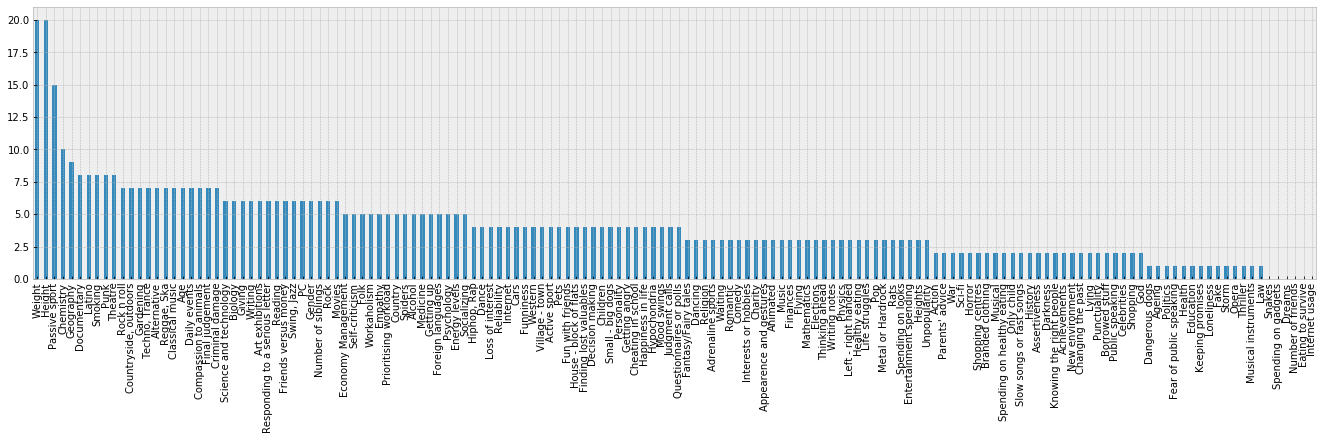

In [9]:
nulls = young.isnull().sum().sort_values(ascending=False)
nulls.plot(kind='bar', figsize=(23, 5))

Missing values are always a pain because we do not know why people did not fill this field or maybe there was a post-processing error (how the data was transfered to the digital form) in the dataset. "In 2013, students of the Statistics class at FSEV UK were asked to invite their friends to participate in this survey." Might be that participants of the survey, knowing that their data will be analyzed by their friends did not provide information like Age, Weight and Height because that are the main features according to which one can be identified.

In [10]:
print('Number of girls who omitted weight field: {:.0f}'.format(
    young[young['Gender'] == 'female']['Weight'].isnull().sum()))
print('Number of boys who omitted weight field: {:.0f}'.format(
    young[young['Gender'] == 'male']['Weight'].isnull().sum()))
print('Number of girls who omitted height field: {:.0f}'.format(
    young[young['Gender'] == 'female']['Height'].isnull().sum()))
print('Number of boys who omitted height field: {:.0f}'.format(
    young[young['Gender'] == 'male']['Height'].isnull().sum()))

Number of girls who omitted weight field: 13
Number of boys who omitted weight field: 6
Number of girls who omitted height field: 13
Number of boys who omitted height field: 6


Outch! Those numbers look weird. There is an amazing observation called Twyman's Law, which states: "Any piece of data or evidence that looks interesting or unusual is probably wrong!" Lets zoom on individuals of those NAs values.

In [11]:
omitted = young[(young['Weight'].isnull()) | young['Height'].isnull()]
print('Number of people with omitted weight or height: {:.0f}'.format(omitted.shape[0]))
nas = omitted.drop(['Weight', 'Height', 'Number of siblings', 'Age'], 1).isnull().sum().sum()
print('Number of fields that were omitted by people who did not fill Weight or Height: {:.0f}'.format(nas))

Number of people with omitted weight or height: 30
Number of fields that were omitted by people who did not fill Weight or Height: 18


## Understanding our goal

As I mentioned, the focus will be on the analysis of urban and rural areas. So, we drop records that are missing in 'Village - town' column.

Btw as I always try to automatize/generalize things, this kernel can be used for analysis of other variables of interest. Just change 'var_of_interest', mapping and two fields in ML section.

In [12]:
var_of_interest = 'Village - town'
mapping = {var_of_interest: {'city': 0, 'village': 1}}
young.dropna(subset=[var_of_interest], inplace=True)
# to be able to use hue parameter for better comparison in seaborn
young["all"] = ""

(array([0, 1]), <a list of 2 Text yticklabel objects>)

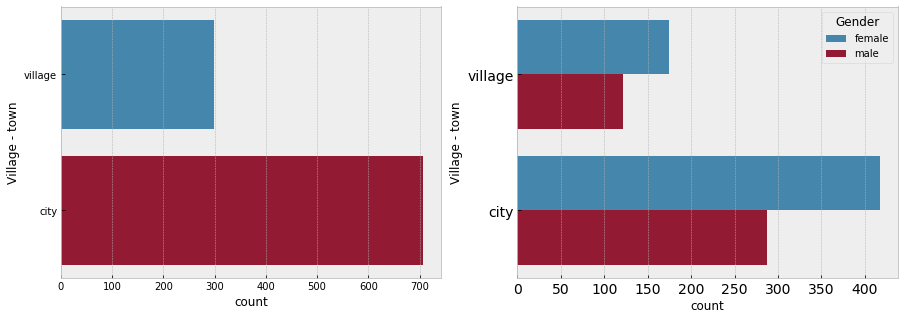

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(y=var_of_interest, data=young, ax=ax[0])
sns.countplot(y=var_of_interest, hue='Gender', data=young, ax=ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

The classes are highly imbalanced, there are twice so many people used to live in city then in the village. Imbalanced classes could be a problem for ML algorithms, we will discuss how to solve it but here are some ideas: oversampling, undersampling, (nice package to use is from imblearn.over_sampling.SMOTE)  and class weights defintions.

## Outliers

Lets have a look if there are any differences in height, weight or age between people from urban and rural areas

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


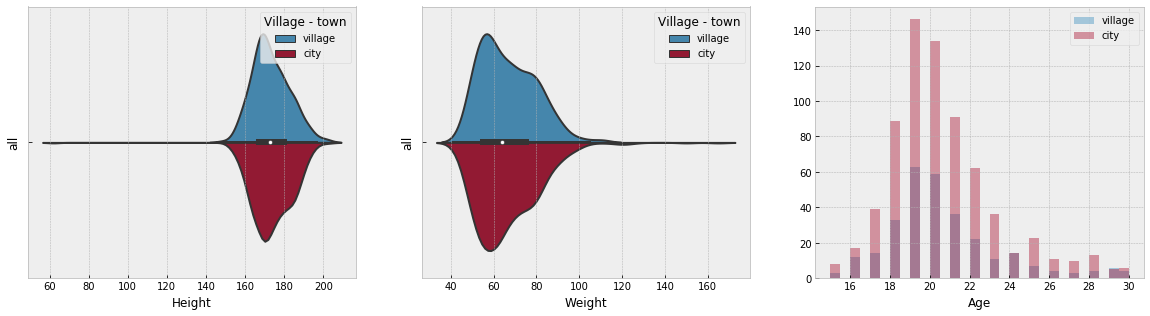

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
data = young.dropna(subset=['Height'])
sns.violinplot(x='Height', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[0]);
data = young.dropna(subset=['Weight'])
sns.violinplot(x='Weight', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[1]);

var_of_int_ser = young[var_of_interest]
sns.distplot(young[var_of_int_ser=='village'].Age.dropna(),
             label='village', ax=ax[2], kde=False, bins=30);

sns.distplot(young[var_of_int_ser=='city'].Age.dropna(),
             label='city', ax=ax[2], kde=False, bins=30);
ax[2].legend()

As we see there are some outliers that disturb the visualisation.

In [16]:
display(young[young['Height']<70][['Age', 'Height', 'Weight', 'Gender', var_of_interest]])
display(young[young['Weight']>120][['Age', 'Height', 'Weight', 'Gender', var_of_interest]])

,Age,Height,Weight,Gender,Village - town
676,20.0,62.0,55.0,female,city


,Age,Height,Weight,Gender,Village - town
859,20.0,190.0,125.0,male,city
885,23.0,NaN,165.0,female,city
992,30.0,200.0,150.0,male,city


Also, keep in mind that participants could have mistaken the fields, so instead of writing their height in 'height' field, they could have written it in 'weight' field (165 kg could be actually intended to be 165 cm) . Or have just made a mistake while filling up the questionnaire (so 62 cm could have been 162 cm).
We will exclude two outliers because they might be just an error in the dataset and two guys who are weight more than 125 kg.

In [17]:
young.drop([676,885,992, 859], inplace = True)

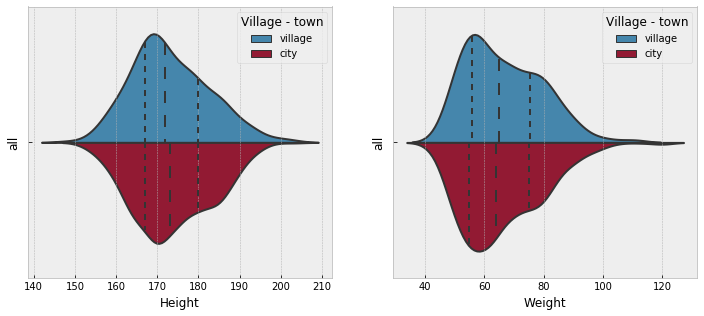

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
data = young.dropna(subset=['Height'])
sns.violinplot(x='Height', y="all", hue=var_of_interest, data=data, 
                   split=True, ax=ax[0], inner='quartile');

data = young.dropna(subset=['Weight'])
sns.violinplot(x='Weight', y="all", hue=var_of_interest, data=data, 
                   split=True, ax=ax[1], inner='quartile');

Interestingly, there is a small second hill in Height in city people around 185 cm. The horizontal lines are quartiles.

## Correlation

Firstly, look at correlations between the characteristics and the urban-rural area. Correlation describes the degree of relationship between two variables. However, it tells nothing about the causuality. Just a small example, the anti-violent gaming policies say that there is a correlation between time spent on playing violent computer games and a violent behaviour. In fact, we do not know if a the computer games make a person violent ora violent person would play more violent games.  

In [19]:
corr = young.corr()

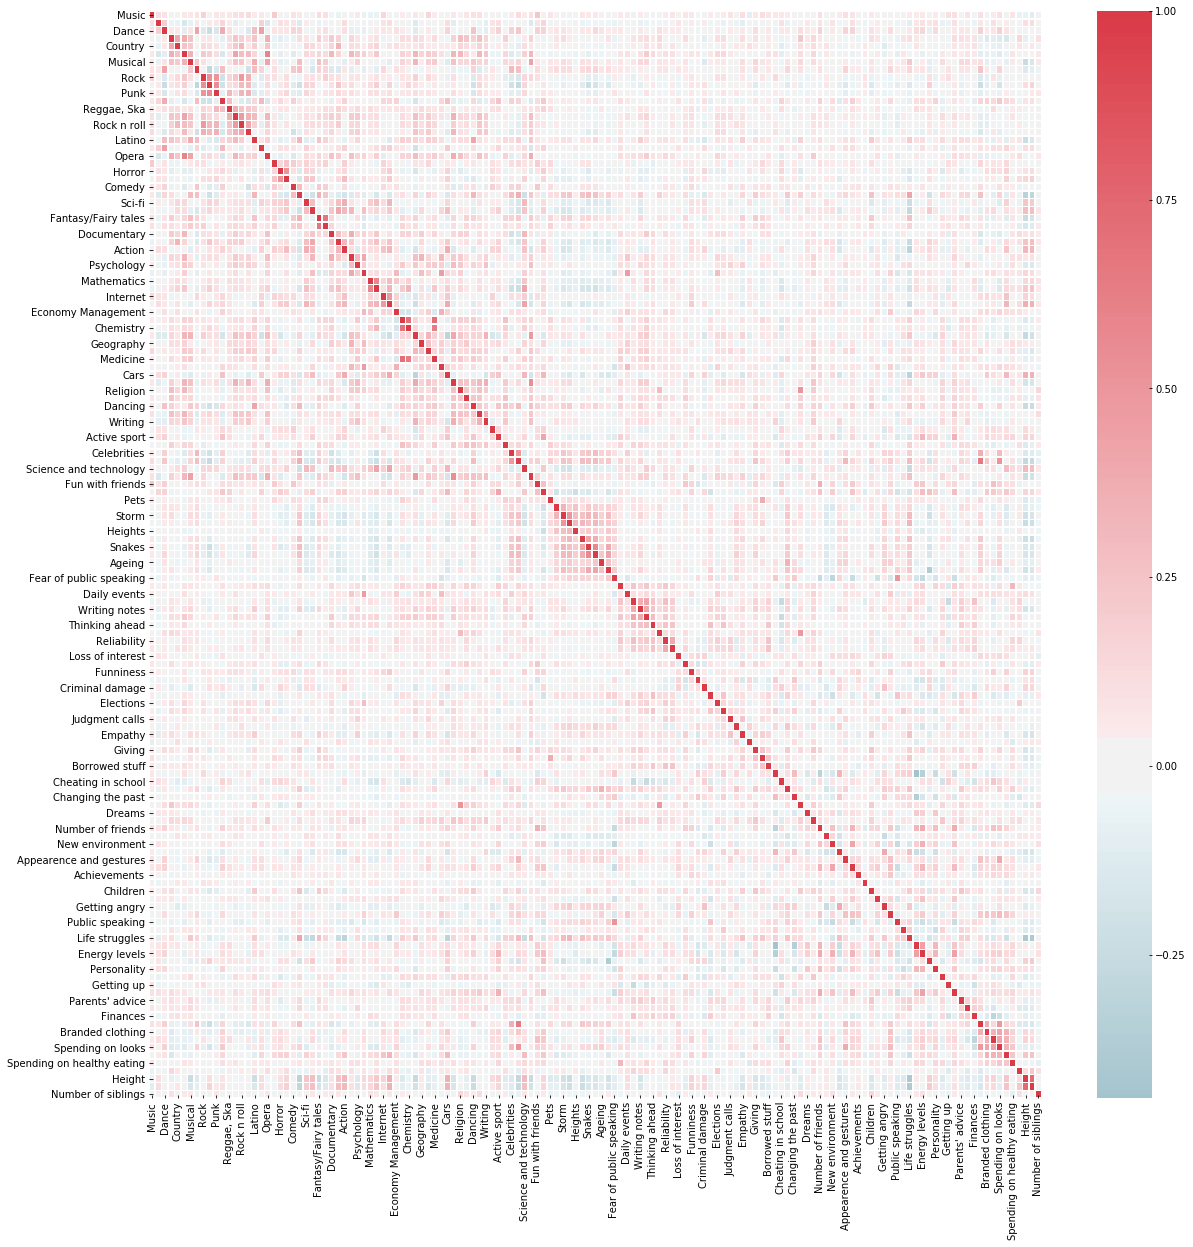

In [20]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  
            center=0,
            linewidths=.5,
            cmap=colormap)

In [21]:
def do_ploting(x, y, figsize):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Correlation coefficient of the variables")
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_ylabel("Correlation coefficients")

In [22]:
def correlation_plot(var_of_interest, df_main, mapping, figsize=(10, 30)):
    def calc_corr(var_of_interest, df, cols, figsize):
        lbls = []
        vals = []
        for col in cols:
            lbls.append(col)
            vals.append(np.corrcoef(df[col], df[var_of_interest])[0, 1])
        corrs = pd.DataFrame({'features': lbls, 'corr_values': vals})
        corrs = corrs.sort_values(by='corr_values')
        do_ploting(corrs.corr_values, corrs['features'], figsize)
        return corrs

    #imputing the set
    df = copy.deepcopy(df_main)
    df.replace(mapping, inplace=True)
    mean_values = df.mean(axis=0)
    df.fillna(mean_values, inplace=True)

    #correlating non-categorical varibales
    cols_floats = [col for col in df.columns if df[col].dtype != 'object']
    cols_floats.remove(var_of_interest)
    corrs_one = calc_corr(var_of_interest, df, cols_floats, figsize)

    #correlating categorical variables
    cols_cats = [col for col in df.columns if df[col].dtype == 'object']
    if cols_cats:
        df_dummies = pd.get_dummies(df[cols_cats])
        cols_cats = df_dummies.columns
        df_dummies[var_of_interest] = df[var_of_interest]
        corrs_two = calc_corr(var_of_interest, df_dummies, cols_cats, (5, 10))
    else:
        corrs_two = 0
    return [corrs_one, corrs_two]

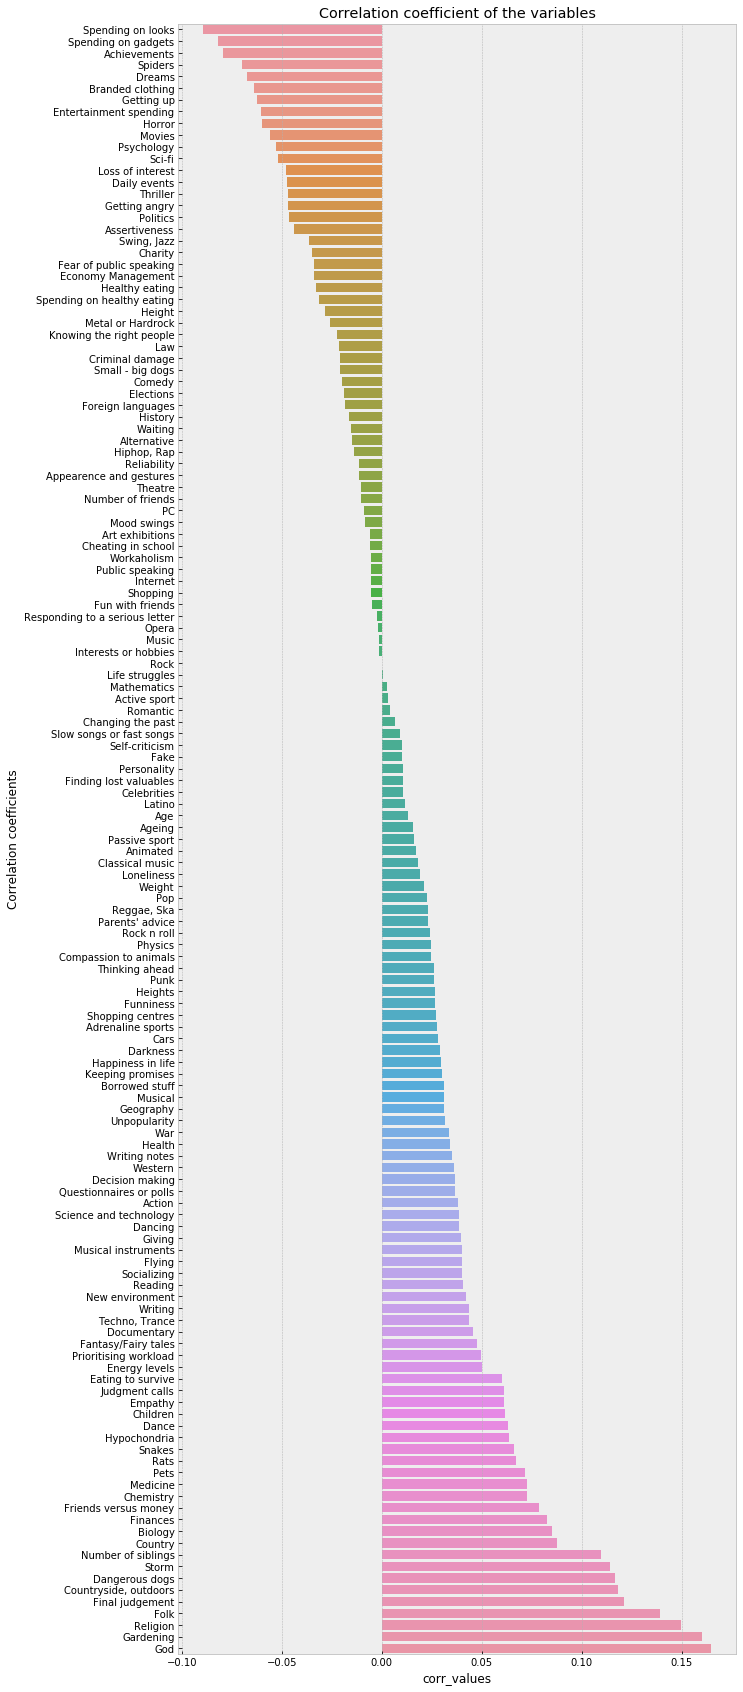

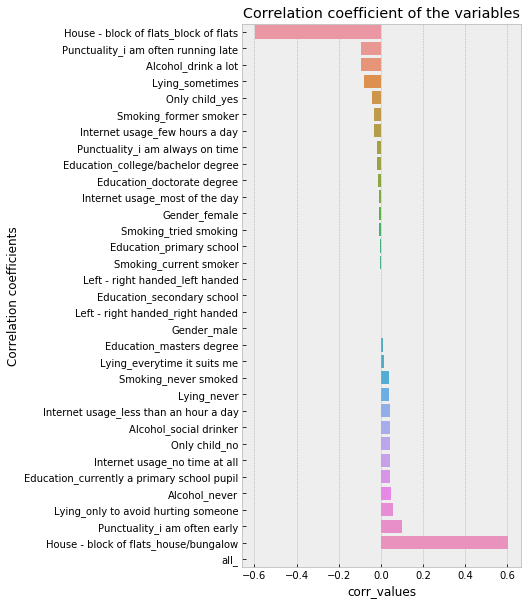

In [23]:
corrs_area = correlation_plot(var_of_interest, young, mapping)

The strongest correlations that we have are coming from the house type and it is quite logical because people in the village would live most of the time in the houses. Other correlations that are not that strong are the associations with God and Spending on looks. 

In [24]:
#The strongest correlations that we have are  
corr_num = corrs_area[0]
corr_cats = corrs_area[1]
display(corr_num[corr_num.corr_values == max(corr_num.corr_values)])
display(corr_num[corr_num.corr_values == min(corr_num.corr_values)])
display(corr_cats[corr_cats.corr_values == max(corr_cats.corr_values)])
display(corr_cats[corr_cats.corr_values == min(corr_cats.corr_values)])

,features,corr_values
101,God,0.164462


,features,corr_values
132,Spending on looks,-0.089162


,features,corr_values
31,House - block of flats_house/bungalow,0.604884


,features,corr_values
30,House - block of flats_block of flats,-0.598687


## Multicollinearity

Apart from outliers and missing values, multicollinearity is another common issue. Some ML algorithms like Random Forest do not suffer from multicollinearity, whereas linear regression could have problems with it. 

So, it would be quite exciting to look which characteristics are correlated in our data set.

In [25]:
corr = young.corr()

os = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
display(os.head(10))
display(os.tail(10))

Height               Weight              0.737569
Biology              Medicine            0.717139
                     Chemistry           0.688564
Fantasy/Fairy tales  Animated            0.676276
Shopping             Shopping centres    0.650689
Chemistry            Medicine            0.629480
Classical music      Opera               0.595599
Mathematics          Physics             0.591291
Snakes               Rats                0.570754
Metal or Hardrock    Punk                0.547129
dtype: float64

Reading            Cars                -0.309490
Cars               Life struggles      -0.313389
Loneliness         Number of friends   -0.315768
Romantic           Height              -0.320189
Loneliness         Energy levels       -0.347802
Changing the past  Happiness in life   -0.354172
Dangerous dogs     Small - big dogs    -0.372104
Life struggles     Weight              -0.382689
                   Height              -0.398125
Loneliness         Happiness in life   -0.440208
dtype: float64

Meanwhile lets have a look on the correlations amoung out good features.

In [26]:
corr = young[good_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5})

NameError: name 'good_columns' is not defined

In [ ]:
print (os['Entertainment spending'])

In [28]:
corr = young.corr()
os = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
display(os[abs(os)>0.5])
drop_colinera_cols = os[abs(os)>0.5].reset_index()['level_1']

Height                   Weight               0.737569
Biology                  Medicine             0.717139
                         Chemistry            0.688564
Fantasy/Fairy tales      Animated             0.676276
Shopping                 Shopping centres     0.650689
Chemistry                Medicine             0.629480
Classical music          Opera                0.595599
Mathematics              Physics              0.591291
Snakes                   Rats                 0.570754
Metal or Hardrock        Punk                 0.547129
Art exhibitions          Theatre              0.540432
Rock                     Metal or Hardrock    0.527834
Shopping                 Spending on looks    0.512193
Religion                 God                  0.509766
Rock                     Punk                 0.508960
Fear of public speaking  Public speaking      0.507708
Horror                   Thriller             0.505720
Storm                    Darkness             0.503489
dtype: flo

### Preparing the dataset for ML

In [29]:
clean_data = young.dropna(subset=[var_of_interest])
features_int = [col for col in clean_data.columns if clean_data[col].dtype!='object']
features_cats = [col for col in clean_data.columns if clean_data[col].dtype=='object']

features_int = list(set(features_int) - set(drop_colinera_cols))
print ('Number of features {:.0f}'.format(len(features_int)))

Number of features 123


We will impute missing values with the mean, althought there are some better solutions to do it, like imputing Height and Weight according to the Gender or taking randomly a value in the range [mean - std, mean + std]

In [30]:
X = clean_data[features_int]
mean_values = X.mean(axis=0)
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

In [36]:
from sklearn.model_selection import train_test_split
Y = clean_data[var_of_interest]
for key, val in mapping[var_of_interest].items():
    Y.replace(key,val, inplace = True)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=100)

It is also a good idea to have a look on the distrubtion once me imputed the values to be sure that we did not disrupt it.

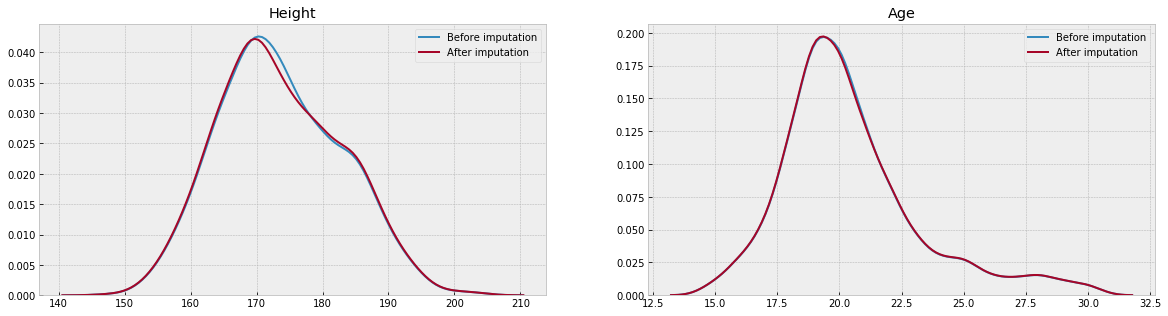

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.kdeplot(X.Height,label = 'Before imputation', ax = ax[0]);
sns.kdeplot(clean_data.Height, label = 'After imputation', ax = ax[0]);
ax[0].set_title('Height');

sns.kdeplot(X.Age,label = 'Before imputation', ax = ax[1]);
sns.kdeplot(clean_data.Age, label = 'After imputation', ax = ax[1]);
ax[1].set_title('Age');